In [1]:
%matplotlib inline

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [43]:
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses 
    
    for item in images:  
        count[item[1]] += 1   
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight       

In [52]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
         transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = './data_for_pytorch/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}


dataset_train = image_datasets['train']                                                                 
                                                                                
# For unbalanced dataset we create a weighted sampler                       
weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))


dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=12), 
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=16,
                                             shuffle=True, num_workers=12)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [45]:
 len(image_datasets['train'].classes)

8

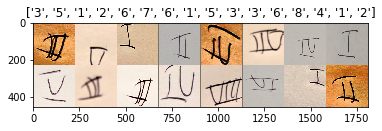

In [33]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [34]:
sorted(image_datasets['train'].classes) == sorted(image_datasets['test'].classes)

True

Training the model
------------------



In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_f_score = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            y_pred = []
            y_test = []

            # Iterate over data.
            for data in tqdm(dataloaders[phase]):
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data.item() * inputs.size(0)
                running_corrects += torch.sum((preds == labels.data))

                y_pred.append(preds.cpu().numpy())
                y_test.append(labels.data.cpu().numpy())

            y_test = np.hstack(y_test)
            y_pred = np.hstack(y_pred)
#             print("y_test", y_test)
#             print("y_pred", y_pred)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = accuracy_score(y_test, y_pred)
            f_score = f1_score(y_test, y_pred, average='weighted')

            print('{} Loss: {:.4f} Acc: {:.4f} F1 score: {:.4f}'.format(
            phase, epoch_loss, epoch_acc, f_score))

            # deep copy the model
            if phase == 'test' and f_score > best_f_score:
                best_f_score = f_score
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val F1 score: {:4f}'.format(best_f_score))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
softmax = torch.nn.Softmax()
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['test']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {} conf: {}'.format(class_names[preds[j]], float(torch.max(softmax(outputs)).data.cpu().numpy())))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [37]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

In [39]:
torch.save(model_ft, 'classifier')

In [53]:
y_pred = []
y_test = []
for data in tqdm(dataloaders['test']):
    # get the inputs
    inputs, labels = data
    # wrap them in Variable
    if use_gpu:
        inputs = Variable(inputs.cuda())
        labels = Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)

                # forward
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs.data, 1)
   

    y_pred.append(preds.cpu().numpy())
    y_test.append(labels.data.cpu().numpy())

y_test = np.hstack(y_test)
y_pred = np.hstack(y_pred)

100%|██████████| 3/3 [00:00<00:00,  4.06it/s]


In [54]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       1.00      0.88      0.93         8
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       0.88      1.00      0.93         7
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         3

   micro avg       0.98      0.98      0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


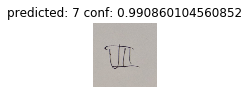

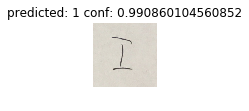

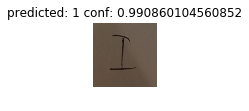

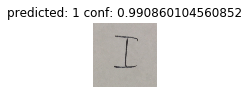

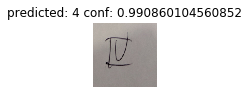

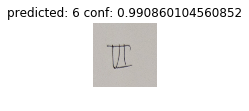

In [55]:
visualize_model(model_ft)